# Two-Stage Global Fit

1.	Generate n number of replicas from whichever local fitting method we conclude is optimal for each kinematic set of which we have m, thus producing a nxm matrix for each Compton Form Factor.
2.	Define and compile a neural network, or other model form, with some set of as yet undetermined hyperparameters.
3.	Train n copies of that model on each row of that matrix, meaning each model sees m data points.  Repeat this for each Compton Form Factor.
4.	To interpolate a value of F for a novel kinematic set, feed that kinematic set into each model, producing n predictions of each CFF.  The mean of that n-sized vector would be the point estimate of our CFF, and the standard deviation would be our error.

## Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn.preprocessing import MinMaxScaler

import utilities as uts

In [4]:
from TVA1_UU import TVA1_UU #modified bhdvcs file

## Setup

In [9]:
len(np.unique(df['#Set']))

342

In [5]:
numSets = 342
numReplicas = 100

bhdvcs = TVA1_UU()

df = pd.read_csv("dvcs_May21.csv")
data = uts.DvcsData(df)

localFits = np.fromfile('replicas100.txt')
localFits = localFits.reshape(numSets, numReplicas, 3)

## Define model

In [11]:
kinematics = tf.keras.Input(shape=(4))
x = tf.keras.layers.Dense(20, activation="relu")(kinematics)
x = tf.keras.layers.Dense(20, activation="relu")(x)
outputs = tf.keras.layers.Dense(3)(x)

globalModel = tf.keras.Model(inputs=kinematics, outputs=outputs, name="GlobalModel")

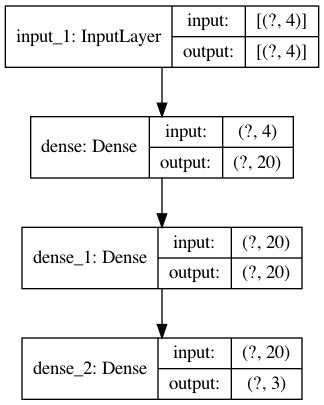

In [12]:
tf.keras.utils.plot_model(globalModel, "cffs.png", show_shapes=True)

In [37]:
X = data.Kinematics.loc[np.array(range(numSets))*45, :].reset_index(drop=True)

#y = np.array(data.CFFs.loc[np.array(range(numSets))*45, :].reset_index(drop=True))

In [19]:
rescaler = MinMaxScaler()

rescaler = rescaler.fit(X)
X_rescaled = rescaler.transform(X)

In [20]:
globalModel.compile(optimizer=tf.keras.optimizers.Adam(.1), loss=tf.keras.losses.MeanSquaredError())
orig_weights = globalModel.get_weights()

# Produce results

In [21]:
def produceResults(model, X, localFits, orig_weights, numSets, numReplicas, folder_name, epochs=250):
    '''
    Essentially LOO cross-val with y-values being generated from seperate local fit
    
    globalModel: a tensorflow neural network model
    X: standardized kinematic variables
    orig_weights: the original weights from when the model was created (used to reset model after it has been trained)
    numSets: the number of kinematic sets
    numReplicas: the number of replicas
    
    returns: np array of cff predictions of shape (numSets, numReplicas, numCFFs)
    '''

    for rep in range(numReplicas):
        train_y = localFits[:, rep, :]

        model.set_weights(orig_weights)
        model.fit(X, train_y, epochs=epochs, verbose=0)
        model.save(folder_name + '/' + 'model' + str(rep) + '.h5')

In [22]:
results = produceResults(globalModel, X_rescaled, localFits, orig_weights, numSets, numReplicas, 'M4mods')

# Global Plot

In [63]:
localFits[:, :, 2].mean(axis=1).mean()

2.0968531732600413

In [35]:
localFits.shape

(342, 100, 3)

In [69]:
def graph_localFits(localFits, X, which_kin, cff_num, ylim=None):
    if ylim:
        plt.ylim(ylim)
    plt.plot(X[which_kin], localFits[:, :, cff_num].mean(axis=1), 'o')
    plt.xlabel(which_kin)
    plt.ylabel(['ReH', 'ReE', 'ReHtilde'][cff_num])

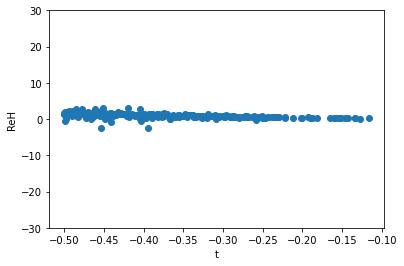

In [77]:
graph_localFits(localFits, X, 't', 0, (-30, 30))

## Results

### ReH

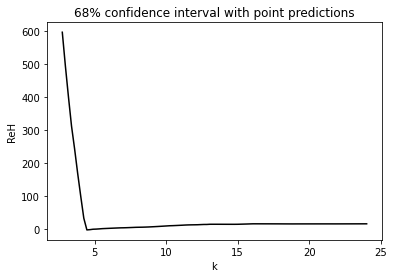

In [29]:
uts.c_int_plot('M4mods', data, 'k', 0)

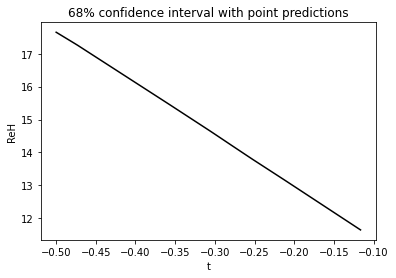

In [30]:
uts.c_int_plot('M4mods', data, 't', 0)

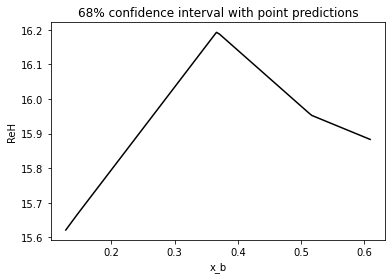

In [31]:
uts.c_int_plot('M4mods', data, 'x_b', 0)

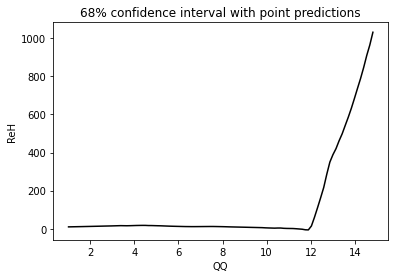

In [34]:
uts.c_int_plot('M4mods', data, 'QQ', 0)

### ReE

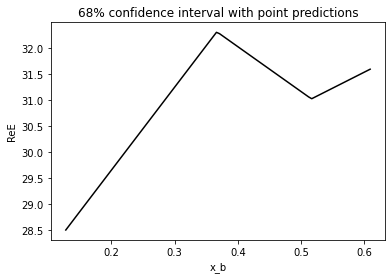

In [32]:
uts.c_int_plot('M4mods', data, 'x_b', 1)

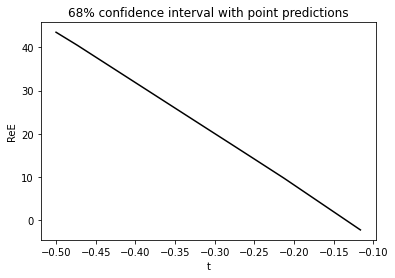

In [76]:
uts.c_int_plot('M4mods', data, 't', 1)

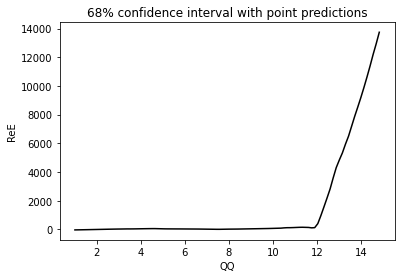

In [78]:
uts.c_int_plot('M4mods', data, 'QQ', 1)

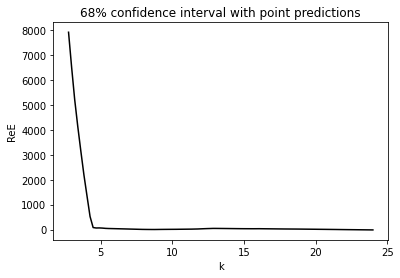

In [79]:
uts.c_int_plot('M4mods', data, 'k', 1)

### ReHtilde

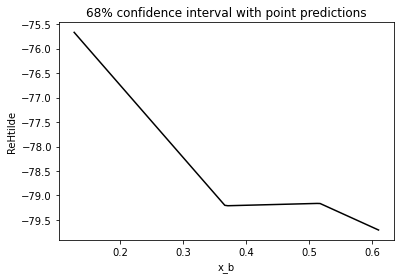

In [33]:
uts.c_int_plot('M4mods', data, 'x_b', 2)

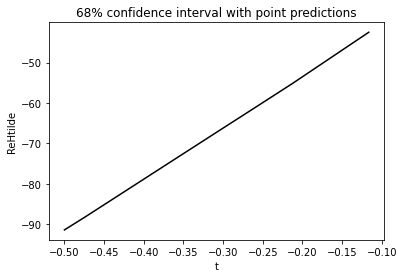

In [80]:
uts.c_int_plot('M4mods', data, 't', 2)

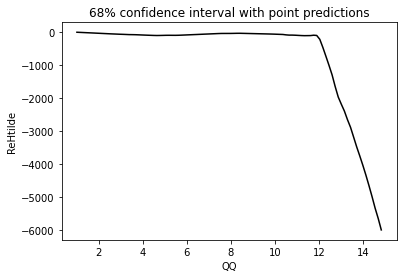

In [81]:
uts.c_int_plot('M4mods', data, 'QQ', 2)

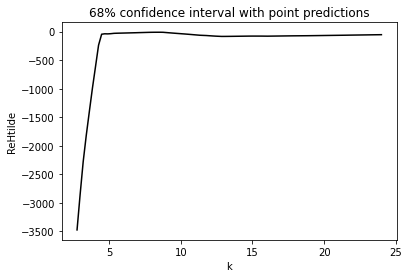

In [82]:
uts.c_int_plot('M4mods', data, 'k', 2)

# Actual Functions

$$ReH = 5t^2 + 2x_b^2$$

$$ReE = 4.5t + -1.5x_b^2$$

$$ReHtilde = -5.5t + 4.5x_b$$